In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import osmnx as ox
import matplotlib.pyplot as plt
ox.config(log_file=True, log_console=True, use_cache=True)
import PyPDF2
import re
import warnings
from tqdm import tqdm
from glob import glob
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

# Creating a Luzon Boundary

In [2]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2021", 
                 password="5HOA&yn6$B", 
                 host="192.168.212.99", 
                 port=32771)

In [3]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon, Philippines').areaId()

In [4]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId,
                             elementType='relation',
                             selector='"admin_level"="2.5"',
                             includeGeometry=True,out='body')
result = overpass.query(query)

In [5]:
result.elements()[0].tags()

{'admin_level': '2.5',
 'alt_name': 'Luzon Island Group',
 'boundary': 'administrative',
 'name': 'Luzon',
 'type': 'boundary',
 'wikidata': 'Q2673519',
 'wikipedia': 'nl:Luzon (eilandengroep)'}

In [6]:
df = pd.DataFrame(columns=['Name','geom'])
geo = gpd.read_file(str(result.elements()[0].geometry()))['geometry'][0]
df.loc[0] = [result.elements()[0].tag('name'),geo]
gdf = gpd.GeoDataFrame(df, geometry=df.geom)
gdf

,Name,geom,geometry
0,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...","MULTIPOLYGON (((118.50156 7.62508, 118.56418 7..."


<AxesSubplot:>

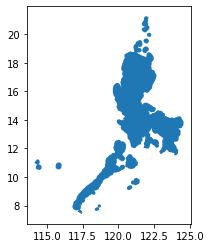

In [7]:
gdf.plot()

# Creating the Luzon Cities

In [8]:
ph_shp = gpd.read_postgis('''
SELECT * 
FROM gadm.ph
''',conn,geom_col='geom')
ph_shp.head()

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,None,Bayan|Munisipyo,Municipality,140101,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ..."
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,None,None,Bayan|Munisipyo,Municipality,140102,PH.AB.BL,"MULTIPOLYGON (((120.99042 17.39802, 120.98631 ..."
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,None,None,Bayan|Munisipyo,Municipality,140103,PH.AB.BU,"MULTIPOLYGON (((120.70788 17.45395, 120.70621 ..."
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,None,None,Bayan|Munisipyo,Municipality,140104,PH.AB.BC,"MULTIPOLYGON (((120.78956 17.41699, 120.78922 ..."
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,None,None,Bayan|Munisipyo,Municipality,140105,PH.AB.DG,"MULTIPOLYGON (((120.92917 17.41307, 120.92464 ..."


<AxesSubplot:>

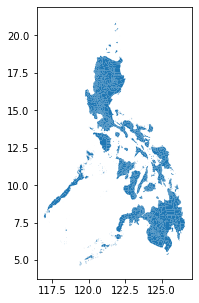

In [9]:
ph_shp.plot(figsize=(5,5))

In [10]:
luzon = gpd.overlay(gdf, ph_shp, how='intersection')

<AxesSubplot:>

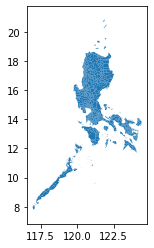

In [11]:
luzon.plot()

# Creating the Centroid of the Cities

In [12]:
luzon['centroid'] = luzon.centroid

df_luzon = luzon[['name_1','name_2','centroid']]
df_luzon  = gpd.GeoDataFrame(df_luzon , geometry=df_luzon.centroid)
df_luzon.head()

,name_1,name_2,centroid,geometry
0,Abra,Bangued,POINT (120.60718 17.60052),POINT (120.60718 17.60052)
1,Abra,Boliney,POINT (120.86822 17.37966),POINT (120.86822 17.37966)
2,Abra,Bucay,POINT (120.72253 17.52285),POINT (120.72253 17.52285)
3,Abra,Bucloc,POINT (120.84761 17.43768),POINT (120.84761 17.43768)
4,Abra,Daguioman,POINT (120.95165 17.45102),POINT (120.95165 17.45102)


<AxesSubplot:>

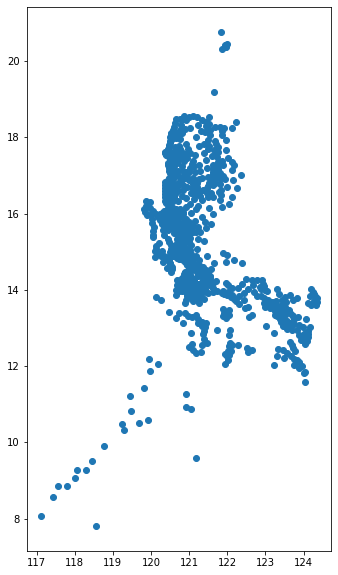

In [13]:
df_luzon.plot(figsize=(10,10))

# Merge Luzon with Population

In [14]:
pop = pd.read_csv('financial_pop.csv')
pop.head()

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


In [15]:
gdf_pop = df_luzon.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])
gdf_pop = gdf_pop.dropna()
gdf_pop.head()

,name_1,name_2,centroid,geometry,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,Abra,Bangued,POINT (120.60718 17.60052),POINT (120.60718 17.60052),48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,Abra,Boliney,POINT (120.86822 17.37966),POINT (120.86822 17.37966),3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,Abra,Bucay,POINT (120.72253 17.52285),POINT (120.72253 17.52285),17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,Abra,Bucloc,POINT (120.84761 17.43768),POINT (120.84761 17.43768),2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,Abra,Daguioman,POINT (120.95165 17.45102),POINT (120.95165 17.45102),2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


# Creating and Plotting the Substations

In [16]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon,Philippines').areaId()

In [17]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='way', selector='"power"="substation"', includeGeometry=True,out='body')
result = overpass.query(query)
result.countElements()

494

In [18]:
df_subs = pd.DataFrame(columns=['id','name','geom'])
for y,x in enumerate(result.elements()):
    list1 = []
    try:
        geo = gpd.read_file(str(x.geometry()))['geometry'][0]
        df_subs.loc[y] = [x.id(),x.tag('name'),geo]
    except:
        print(x.tag('name'))
        pass

In [19]:
gdf_subs = gpd.GeoDataFrame(df_subs, geometry=df_subs.geom)
gdf_subs.head()

,id,name,geom,geometry
0,28701585,Balibago Substation,"POLYGON ((121.102106 14.293563, 121.101882 14....","POLYGON ((121.10211 14.29356, 121.10188 14.293..."
1,30331256,Magallanes Substation,"POLYGON ((121.020812 14.537707, 121.02112 14.5...","POLYGON ((121.02081 14.53771, 121.02112 14.537..."
2,30618817,Paco Substation,"POLYGON ((120.99821 14.58017, 120.998159 14.58...","POLYGON ((120.99821 14.58017, 120.99816 14.580..."
3,30665662,San Jose del Monte Substation,"POLYGON ((121.044865 14.818748, 121.046158 14....","POLYGON ((121.04487 14.81875, 121.04616 14.818..."
4,30679817,Sampaloc Substation,"POLYGON ((120.990661 14.612684, 120.990579 14....","POLYGON ((120.99066 14.61268, 120.99058 14.612..."


# dropping the Null Names of substations

In [20]:
subs_luzon = gpd.overlay(gdf, gdf_subs, how='intersection')[['name','geometry']]
subs_luzon['centroid'] = subs_luzon.centroid
subs_luzon = subs_luzon[['name','centroid']]
subs_luzon  = gpd.GeoDataFrame(subs_luzon , geometry=subs_luzon.centroid)

#dropping none values of substation names

subs_luzon = subs_luzon[~subs_luzon['name'].isnull()]
subs_luzon['matchingname1'] = subs_luzon['name'].str.replace(' Substation','').str.lower()
subs_luzon.head()

,name,centroid,geometry,matchingname1
0,Balibago Substation,POINT (121.10201 14.29399),POINT (121.10201 14.29399),balibago
1,Magallanes Substation,POINT (121.02138 14.53764),POINT (121.02138 14.53764),magallanes
2,Paco Substation,POINT (120.99863 14.58055),POINT (120.99863 14.58055),paco
3,San Jose del Monte Substation,POINT (121.04724 14.82088),POINT (121.04724 14.82088),san jose del monte
4,Sampaloc Substation,POINT (120.99046 14.61261),POINT (120.99046 14.61261),sampaloc


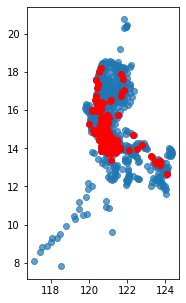

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
gdf_pop.plot(ax=ax,alpha=0.7)
subs_luzon.plot(ax=ax,color='red');

# Creating a bounding box to limit only within the substation

In [22]:
from shapely.geometry import Point, Polygon
bbox = subs_luzon.total_bounds

p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])

df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

df3 = gpd.overlay(df2, luzon)

df4 = df3.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])
df4.head()

,Name,geom,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,...,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,...,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,...,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,...,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,...,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,...,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


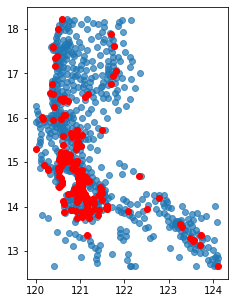

In [23]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
df4.centroid.plot(ax=ax,alpha=0.7)
subs_luzon.plot(ax=ax,color='red');

# Parsing the IEMOP PDF

In [24]:
fixed_pdf = PyPDF2.PdfFileReader('datasets/energy/WESM-MNM_182.pdf')
p29 = fixed_pdf.getPage(29).extractText()
p29=p29.replace('\n4\n','\n').replace('\n3\n','\n')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p29)[0]
p29l = re.findall(r'(\n.+?\n \n.+?\n)',des)

dfa = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p29l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    dfa.loc[y] = [x1,x2]
dfa.loc[11,'name']='Santiago'
dfa=dfa.drop_duplicates()

In [25]:
p27 = fixed_pdf.getPage(27).extractText()
p27=p27.replace('\n2\n','\n').replace('\n3\n','\n')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p27)[0]
p27l = re.findall(r'(\n.+?\n \n.+?\n)',des)
df1a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p27l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df1a.loc[y] = [x1,x2]
df1a.loc[8,'name']='La Union'
df1a=df1a.drop_duplicates()

In [26]:
p28 = fixed_pdf.getPage(28).extractText()
p28=p28.replace('\n2\n','\n').replace('\n3\n','\n').replace('\n-\n','').replace(' \nPlant\n',' ')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p28)[0]
p28l = re.findall(r'(\n.+?\n \n.+?\n)',des)
df2a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p28l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df2a.loc[y] = [x1,x2]
df2a.loc[35,'name']='GN'
df2a.loc[43,'name']='San Esteban'
df2a=df2a.drop_duplicates()

In [27]:
p30 = fixed_pdf.getPage(30).extractText()
p30=p30.replace('\n2\n','\n').replace('\n3\n','\n').replace('\n-\n','').replace(' \nPlant\n',' ')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nsubject',p30)[0]
p30l = re.findall(r'(\n.+?\n \n.+?\n)',des)[:-2]
df3a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p30l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df3a.loc[y] = [x1,x2]
df3a=df3a.drop_duplicates()

In [28]:
df4a = pd.concat([dfa,df1a,df2a,df3a]).reset_index(drop=True)
df4a['matchingname2'] = df4a['name'].str.lower()
df4a.head()

,code,name,matchingname2
0,1SNEST,San Esteban,san esteban
1,1SNJOS,San Jose,san jose
2,1SNJOSE,San Jose,san jose
3,1SNMAN,San Manuel,san manuel
4,1SNTGO,Santiago,santiago


# Filtering only the subsation that are in iemop

In [29]:
subs_iemop = subs_luzon[subs_luzon['matchingname1'].isin(df4a['matchingname2'])]
subs_iemop = subs_iemop.reset_index(drop=True)
len(subs_iemop)

35

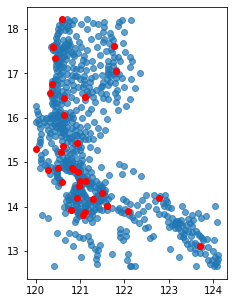

In [30]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
df4.centroid.plot(ax=ax,alpha=0.7)
subs_iemop.plot(ax=ax,color='red');

# Getting the closest substation to the cities

In [31]:
c = []
df4['substation'] = None
for x in range(0,len(df4)):
    shortest_sub = subs_iemop.distance(df4.centroid[x]).sort_values().index[0]
    df4.loc[x,'substation'] = subs_iemop.loc[shortest_sub]['matchingname1']

In [32]:
ratio1 = df4[['pop','substation']].groupby('substation').sum().to_dict()['pop']
df4['pop_total_subs'] = df4['substation'].map(ratio1)
df4['ratio_pop'] = df4['pop']/df4['pop_total_subs']
df4[['name_2','pop','substation','ratio_pop']].head()

,name_2,pop,substation,ratio_pop
0,Bangued,48163.0,bantay,0.104548
1,Boliney,3573.0,san esteban,0.007623
2,Bucay,17115.0,san esteban,0.036517
3,Bucloc,2501.0,san esteban,0.005336
4,Daguioman,2088.0,san esteban,0.004455


In [33]:
subs_version2 = subs_luzon[subs_luzon['matchingname1'].isin(df4['substation'])]

# Getting the Amenities within the Cities

In [34]:
provinces = ('Abra', 'Apayao', 'Benguet', 'Ifugao', 'Kalinga', 
            'Mountain Province','Metropolitan Manila', 'Ilocos Norte', 
            'Ilocos Sur', 'La Union', 'Pangasinan', 'Cagayan', 'Isabela', 
            'Nueva Vizcaya','Quirino','Aurora', 'Bataan', 'Bulacan', 
            'Nueva Ecija', 'Pampanga', 'Tarlac', 'Zambales', 'Batangas', 
            'Cavite', 'Laguna', 'Quezon', 'Rizal', 'Albay', 'Camarines Norte',
            'Camarines Sur','Sorsogon', 'Catanduanes', 'Marinduque', 
            'Occidental Mindoro', 'Oriental Mindoro','Romblon')

amenities = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, g.name_3, p.amenity,
                               st_area(st_transform(st_union(g.geom), 3123))/(1000^2) AS area, 
                               count(*) AS count_amenities
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.amenity IS NOT NULL
                        GROUP BY g.name_1, g.name_2, g.name_3, p.amenity
                        ORDER BY count_amenities DESC
                        """, conn)
amenities

,name_1,name_2,name_3,amenity,area,count_amenities
0,Metropolitan Manila,Makati City,Post Proper Northside,restaurant,3.239744,203
1,Metropolitan Manila,Makati City,San Lorenzo,bank,1.900705,148
2,Metropolitan Manila,Makati City,San Lorenzo,restaurant,1.900705,143
3,Laguna,Los Baños,Batong Malake,bench,9.775445,130
4,Metropolitan Manila,Makati City,Bel-Air,restaurant,1.689471,118
...,...,...,...,...,...,...
19376,Metropolitan Manila,Kalookan City,Barangay 107,hospital,0.049397,1
19377,Metropolitan Manila,Kalookan City,Barangay 107,police,0.049397,1
19378,Metropolitan Manila,Kalookan City,Barangay 108,atm,0.051051,1
19379,Metropolitan Manila,Kalookan City,Barangay 108,fast_food,0.051051,1


In [35]:
amenities = amenities.groupby(['name_2','amenity']).sum()['count_amenities'].reset_index()

In [36]:
len(amenities.name_2.unique())

572

In [37]:
amenities_count = pd.pivot_table(amenities, values='count_amenities', 
                                 index=['name_2'],
                                 columns='amenity' ).fillna(0).reset_index()
amenities_count

amenity,name_2,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,CheckPoint,Highway,Home Parking2,Kapampangan cuisine,...,waste_basket,waste_disposal,waste_transfer_station,water_point,waterwell,wayside_shrine,wellness,wheeler,wrecker_service,yes
0,Abra de Ilog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abucay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abulug,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Agdangan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Villasis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568,Villaverde,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
569,Vinzons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
570,Virac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Getting the Demand Energy 

In [38]:
demand = pd.read_csv('datasets/energy/energydemand.csv').dropna()

In [39]:
def clearname(x):
    x = re.findall(r'(.+)_',x)[0]
    return x

In [40]:
demand['name2'] = demand['RESOURCE_ID'].apply(clearname)

In [41]:
def clean_data(x):
    x1 = x.split('/')
    return pd.Series([x1[2],x1[0],x1[1]])

In [42]:
demand2 = demand[demand['name2'].isin(df4a['code'])]
demand3 = demand2.groupby(['name2','DELIVERY_DATE','DELIVERY_HOUR']).sum().reset_index()
demand3[['Year','Month','Day']] = demand3['DELIVERY_DATE'].apply(clean_data)
demand3['Time'] = demand3['DELIVERY_HOUR']
demand3 = demand3[['name2','Year','Month','Day','Time','MW']]
demand3

,name2,Year,Month,Day,Time,MW
0,1AEC,2021,02,01,1.0,24.7
1,1AEC,2021,02,01,2.0,23.9
2,1AEC,2021,02,01,3.0,22.9
3,1AEC,2021,02,01,4.0,22.3
4,1AEC,2021,02,01,5.0,22.4
...,...,...,...,...,...,...
153787,3TAYAB,2021,04,30,20.0,73.1
153788,3TAYAB,2021,04,30,21.0,71.3
153789,3TAYAB,2021,04,30,22.0,69.4
153790,3TAYAB,2021,04,30,23.0,64.3


# Get only February

In [43]:
demand4 = demand3.query('Month == "02"')
demand4

,name2,Year,Month,Day,Time,MW
0,1AEC,2021,02,01,1.0,24.7
1,1AEC,2021,02,01,2.0,23.9
2,1AEC,2021,02,01,3.0,22.9
3,1AEC,2021,02,01,4.0,22.3
4,1AEC,2021,02,01,5.0,22.4
...,...,...,...,...,...,...
152323,3TAYAB,2021,02,28,20.0,68.3
152324,3TAYAB,2021,02,28,21.0,66.3
152325,3TAYAB,2021,02,28,22.0,63.3
152326,3TAYAB,2021,02,28,23.0,59.0


# Merging all Data

In [44]:
df5 = pd.DataFrame(df4[['shp_province','shp_municipality', 'substation','ratio_pop']])
df5['code'] = df5['substation'].map(df4a[['matchingname2','code']].set_index('matchingname2').to_dict()['code'])
df5

,shp_province,shp_municipality,substation,ratio_pop,code
0,Abra,Bangued,bantay,0.104548,1BPC
1,Abra,Boliney,san esteban,0.007623,1SE
2,Abra,Bucay,san esteban,0.036517,1SE
3,Abra,Bucloc,san esteban,0.005336,1SE
4,Abra,Daguioman,san esteban,0.004455,1SE
...,...,...,...,...,...
668,Zambales,Palauig,botolan,0.092393,1BOTOL
669,Zambales,San Antonio,olongapo,0.065492,1OLONG
670,Zambales,San Felipe,botolan,0.061291,1BOTOL
671,Zambales,San Marcelino,olongapo,0.063610,1OLONG


In [45]:
df6 = df5.merge(amenities_count,left_on=['shp_municipality'],right_on=['name_2']).drop(['name_2'],axis=1)
df6

,shp_province,shp_municipality,substation,ratio_pop,code,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,...,waste_basket,waste_disposal,waste_transfer_station,water_point,waterwell,wayside_shrine,wellness,wheeler,wrecker_service,yes
0,Abra,Bangued,bantay,0.104548,1BPC,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abra,Dolores,bantay,0.024562,1BPC,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Quezon,Dolores,calauan,0.018785,3CALAU,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abra,La Paz,bantay,0.033509,1BPC,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tarlac,La Paz,concepcion,0.056414,1CNCEP,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,Zambales,Olongapo City,olongapo,0.440330,1OLONG,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
603,Zambales,Palauig,botolan,0.092393,1BOTOL,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
604,Zambales,San Felipe,botolan,0.061291,1BOTOL,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
605,Zambales,San Marcelino,olongapo,0.063610,1OLONG,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
working_df = demand4.merge(df6,
                           left_on=['name2'],
                           right_on=['code']).drop(['name2'],axis=1)
working_df['Demand'] = working_df['MW']*working_df['ratio_pop']
working_df = working_df.drop(['MW','ratio_pop'],axis=1)
working_df[['Year','Month','Day','Time']] = working_df[['Year','Month','Day','Time']].astype('int32')
working_df

,Year,Month,Day,Time,shp_province,shp_municipality,substation,code,BPI ATM,Barangay Hall,...,waste_disposal,waste_transfer_station,water_point,waterwell,wayside_shrine,wellness,wheeler,wrecker_service,yes,Demand
0,2021,2,1,1,La Union,Burgos,bauang,1BAUAN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415300
1,2021,2,1,1,La Union,Agoo,bauang,1BAUAN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.278951
2,2021,2,1,1,La Union,Naguilian,bauang,1BAUAN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.791371
3,2021,2,1,1,La Union,Aringay,bauang,1BAUAN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.443203
4,2021,2,1,1,La Union,Caba,bauang,1BAUAN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.134598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407899,2021,2,28,24,Quezon,Lucena City,tayabas,3TAYAB,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.356473
407900,2021,2,28,24,Quezon,Sampaloc,tayabas,3TAYAB,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958818
407901,2021,2,28,24,Quezon,Pagbilao,tayabas,3TAYAB,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.172462
407902,2021,2,28,24,Quezon,Tayabas City,tayabas,3TAYAB,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.879265


# Parse and Clean the Weather Data

In [47]:
def findspeed(x):
    try:
        x1 = re.findall(r'([0-9]+) Km/h',x)[0]
    except:
        x1 = None
    
    return x1

In [48]:
def clouds(x):
    try:
        x1 = re.findall(r' (.+?) Clouds',x)[0]
    except:
        x1 = None
    
    return x1

In [49]:
def clouds_h(x):
    try:
        x1 = re.findall(r'([0-9]+)m',x)[0]
    except:
        x1 = None
    
    return x1

In [50]:
def pres(x):
    try:
        x1 = re.findall(r'([0-9]+?)\.0mb',x)[0]
    except:
        x1 = None
    
    return x1

In [51]:
def timex(x):
    try:
        x1 = re.sub(r':[0-9][0-9]','',x)
    except:
        x1 = None
    
    return x1

In [52]:
from glob import glob
filepaths = glob('datasets/weather/*')
wf = pd.DataFrame()
for x in filepaths:
    df = pd.read_csv(x).drop(['Unnamed: 0','Unnamed: 0.1','Wind Gust','Date'],axis=1)
    df['City']= re.findall(r'weather/(.+?)_',x)[0]
    df['Time'] = df.Time.apply(timex)
    df['Temperature'] = df.Temperature.str.replace("°C",'')
    df['Relative Temperature'] = df['Relative Temperature'].str.replace("°C",'')
    df['Relative Humidity'] = df['Relative Humidity'].str.replace("%",'')
    df['Dew Point'] = df['Dew Point'].str.replace("°C",'')
    df['Pressure'] = df['Pressure'].apply(pres)
    df['Wind Speed'] = df['Wind Speed'].apply(findspeed)
    df['clouds'] = df['Condition'].apply(clouds)
    df['clods_height'] = df['Condition'].apply(clouds_h)
    df = df.drop(['Condition'],axis=1)
    wf = wf.append(df)
wf2 = wf[wf['City'].isin(df5['shp_province'])]
wf2[['Year','Month','Day','Time']] =wf2[['Year','Month','Day','Time']].astype('int32')
wf2

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [frame.py:3191]


,Year,Month,Day,Time,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,City,clouds,clods_height
0,2021,2,1,2,17,17,4,94,16,1015,Abra,Few,550
1,2021,2,1,5,17,17,4,94,16,1015,Abra,Few,550
2,2021,2,1,6,17,17,4,94,16,1015,Abra,Few,550
3,2021,2,1,7,17,17,2,94,16,1016,Abra,Few,550
4,2021,2,1,8,21,21,6,78,17,1016,Abra,Few,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,2021,4,30,19,31,35,7,62,23,1010,Zambales,Few,610
2107,2021,4,30,21,29,34,7,74,24,1013,Zambales,Few,610
2108,2021,4,30,22,28,32,7,79,24,1014,Zambales,Few,610
2109,2021,4,30,23,27,30,7,84,24,1014,Zambales,Few,610


# Get Final Dataset(Merge with working df)

In [53]:
working_df2 = working_df.merge(wf2,left_on=['Year','Month','Day','Time','shp_province'],
                               right_on=['Year','Month','Day','Time','City'])
working_df2 =working_df2.drop(['Year','Month','City','shp_province','substation', 'code','clouds','shp_municipality'],axis=1)
dataset = working_df2.astype('float64')
dataset = dataset.dropna()
dataset

,Day,Time,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,CheckPoint,Highway,Home Parking2,...,wrecker_service,yes,Demand,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,clods_height
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.033720,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.618290,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.758037,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.800885,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.520885,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351678,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.527928,26.0,28.0,7.0,89.0,24.0,1012.0,610.0
351679,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.129331,26.0,28.0,7.0,89.0,24.0,1012.0,610.0
351680,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.240042,26.0,28.0,7.0,89.0,24.0,1012.0,610.0
351681,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.094311,26.0,28.0,7.0,89.0,24.0,1012.0,610.0


In [54]:
dataset.columns

Index(['Day', 'Time', 'BPI ATM', 'Barangay Hall', 'Barangay Yakal Hall',
       'Barangay_Police_Outpost', 'Basketball Court', 'CheckPoint', 'Highway',
       'Home Parking2',
       ...
       'wrecker_service', 'yes', 'Demand', 'Temperature',
       'Relative Temperature', 'Wind Speed', 'Relative Humidity', 'Dew Point',
       'Pressure', 'clods_height'],
      dtype='object', length=256)

# Training on First 20 Days

In [55]:
rang = range(0,21)
filtered = dataset.query('Day in @rang')
filtered

,Day,Time,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,CheckPoint,Highway,Home Parking2,...,wrecker_service,yes,Demand,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,clods_height
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.033720,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.618290,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.758037,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.800885,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.520885,22.0,22.0,7.0,78.0,18.0,1016.0,610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347646,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.367498,26.0,27.0,24.0,70.0,20.0,1012.0,610.0
347647,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.090029,26.0,27.0,24.0,70.0,20.0,1012.0,610.0
347648,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.167096,26.0,27.0,24.0,70.0,20.0,1012.0,610.0
347649,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.065651,26.0,27.0,24.0,70.0,20.0,1012.0,610.0


In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X =filtered.drop(['Demand'],axis=1)
y=filtered['Demand']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [59]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [60]:
print('Train Accuracy is:',LR.score(X_train, y_train))
print('Test Accuracy is:',LR.score(X_test, y_test))

Train Accuracy is: 0.8549201912657771
Test Accuracy is: 0.8514137990324087


In [61]:

from sklearn.ensemble import RandomForestRegressor


In [62]:
# Random Forest
RF = RandomForestRegressor()
RF.fit(X_train, y_train)



RandomForestRegressor()

In [63]:
print('Train Accuracy is:',RF.score(X_train, y_train))
print('Test Accuracy is:',RF.score(X_test, y_test))

Train Accuracy is: 0.9952670692880208
Test Accuracy is: 0.9825219586949548


In [82]:
features = pd.DataFrame(RF.feature_importances_,index = X.columns,columns=['value']).sort_values('value',ascending=False)
features[:]

,value
veterinary,0.272346
car_wash,0.112578
pharmacy,0.085373
school,0.059387
place_of_worship,0.057017
...,...
jeepney station,0.000000
health,0.000000
hardware_store,0.000000
hackerspace,0.000000


In [91]:
f = features.query('value != 0')[:30]

<AxesSubplot:>

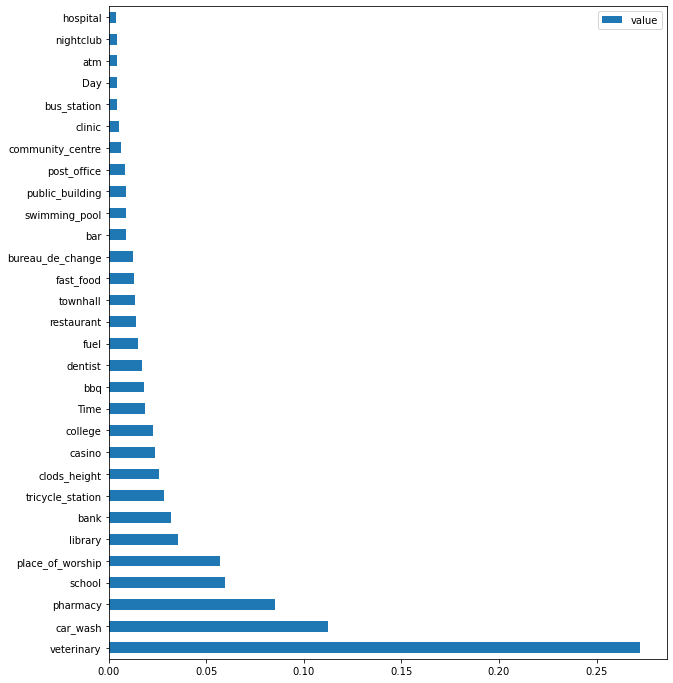

In [107]:
f.plot.barh(figsize=(10,12))